In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'youtube-comments-spam-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5534004%2F9160040%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240831%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240831T132043Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D832b3bdbbc5ebbf6fe55307a54354303f4aac828a9163f3d9afa490ac632e8bf8124cbdbb73f98c626f7626f7da6ccce67ead80f7b599e153bd888c55f8fbebf011cdba8d4502f797e5d4e460c1a6b6ffee6a18462ba35e0a8a66d8b06dc38dd9d0790378c50c58d0555bef6eb7ca45e3db124ab19dfc57db1e15034873c8477c16c7d24e904e658c0b26e00d2fc6f1b2dd9a1286b8c44fbf352a6ba0a2cec394a00b9e0cdeb2ff5bf5e84199038948f1b0752dabe3bb13e445dfa83c35f10dfe1c58395f2b78f6169bd025ff7638bdc6511932f09962db657b23eba1c15ef9952c49523cfa9f19caa9d06b7bb8b79429b6e905fef780d8f65f8bd9bce437dc8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 162831 bytes downloaded
Downloaded and uncompressed: youtube-comments-spam-dataset
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-comments-spam-dataset/Youtube-Spam-Dataset.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("/kaggle/input/youtube-comments-spam-dataset/Youtube-Spam-Dataset.csv")

In [5]:
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,PSY - GANGNAM STYLE(?????) M/V,1


In [8]:
df.shape

(1956, 6)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   VIDEO_NAME  1956 non-null   object
 5   CLASS       1956 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 91.8+ KB


In [11]:
df.isnull().sum()

,0
COMMENT_ID,0
AUTHOR,0
DATE,245
CONTENT,0
VIDEO_NAME,0
CLASS,0


In [15]:
df.duplicated().sum()

3

In [18]:
df.drop_duplicates(inplace=True)

In [17]:
df['CLASS'].value_counts()

,count
CLASS,
1,1005
0,951


In [20]:
df["AUTHOR"].value_counts().sort_values(ascending = False)[:5]


,count
AUTHOR,
M.E.S,8
Louis Bryant,7
Shadrach Grentz,7
5000palo,7
DanteBTV,6


In [21]:
df["VIDEO_NAME"].value_counts().sort_values(ascending = False)[:5]


,count
VIDEO_NAME,
Eminem - Love The Way You Lie ft. Rihanna,446
"LMFAO - Party Rock Anthem ft. Lauren Bennett, GoonRock",438
Shakira - Waka Waka,369
PSY - GANGNAM STYLE(?????) M/V,350
Katy Perry - Roar,350


In [22]:
df["DATE"] =df['DATE'].apply(lambda x: str(x).split('T')[0])

In [23]:
df["DATE"]

,DATE
0,2013-11-07
1,2013-11-07
2,2013-11-08
3,2013-11-09
4,2013-11-10
...,...
1951,2013-07-13
1952,2013-07-13
1953,2013-07-13
1954,2013-07-13


In [24]:
df["DATE"].value_counts().sort_values(ascending=False)[1:5]

,count
DATE,
2014-11-07,74
2014-11-08,68
2015-05-26,66
2015-05-23,59


# **Feature Selection**

In [26]:
df["comment_info"] = df["AUTHOR"] + "  "+df["VIDEO_NAME"]+"  "+df["CONTENT"]

In [27]:
x = df["comment_info"]
y = df["CLASS"]

#**Encoding**

In [28]:
vectorizer = TfidfVectorizer()
x= vectorizer.fit_transform(x)

# **Train Test split**

In [30]:
X_train,X_test , Y_train, Y_test = train_test_split(x,y, test_size = 0.2 , random_state = 42)
X_train.shape , X_test.shape , Y_train.shape, Y_test.shape

((1562, 6980), (391, 6980), (1562,), (391,))

In [31]:
clf = LinearSVC()

In [34]:
clf.fit(X_train, Y_train)

LinearSVC()

# **Evaluation**

In [35]:
y_pred = clf.predict(X_test)

In [36]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       170
           1       0.99      0.94      0.96       221

    accuracy                           0.96       391
   macro avg       0.96      0.96      0.96       391
weighted avg       0.96      0.96      0.96       391



In [37]:
cm = confusion_matrix(Y_test , y_pred)
print(cm)

[[167   3]
 [ 13 208]]


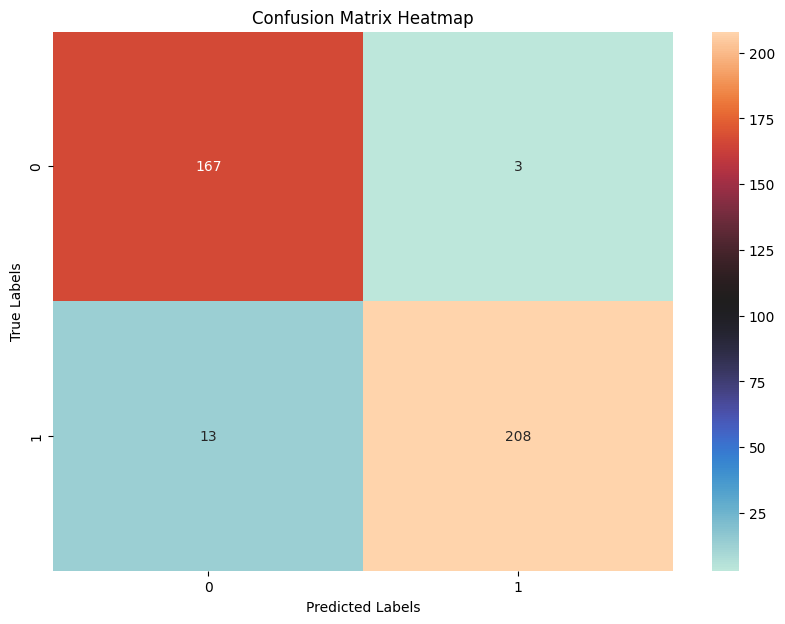

In [38]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='icefire')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()